# Lecture 30


### Singular values

In [1]:
A = randn(20,10);
[U,S,V] = svd(A);

In [2]:
norm(U*S*V' - A)


ans =

   1.8299e-14



## Condition number

Consider the matrix from CP4:

In [3]:
r = RandStream('mt19937ar','Seed',1234);
A = r.randn(6,10);
At = [1e-8*eye(10); A];

Then, let's choose $\vec b$ so that we know the exact solution:

In [4]:
x_true = ones(10,1);
bt = At*x_true;

Let's solve for the least squares solution using the normal equations:

In [5]:
[LU,P] = GEpp(At'*At);
x = applyP(P,At'*bt);
x = Forsub([tril(LU,-1) + eye(10),x]);
x = Backsub([triu(LU),x])


x =

    5.0771
    2.0694
    4.3064
    0.2775
    0.9967
    1.3200
    1.0199
    4.4899
   -3.6066
   -1.9584



If our solution is fully accurate, we'd espect this relative error to be about $2 \times 10^{-16}$:

In [6]:
norm(x-x_true)/norm(x_true)


ans =

    2.6735



We have lost all 16 digits.  This is indeed predicted by the condition number:

In [7]:
cond(At'*At)


ans =

   1.1029e+17



If we use Householder QR we only encounter `At` which has a much smaller condition number:

In [8]:
cond(At)
n = size(At,2);
[~,R] = House([At,bt]);
x = Backsub(R(1:n,1:n+1));
norm(x-x_true)/norm(x_true)


ans =

   5.0409e+08


ans =

   2.6667e-08



We've lost approximately 8 digits, also predicted closely by the condition number.

We can then see what MATLAB does.  It seems to do a little better, but not by much.  I believe it incorporates pivoting in the QR algorithm which helps a little (in this case).

In [9]:
x = At\bt;
norm(x-x_true)/norm(x_true)


ans =

   2.3316e-08



In [10]:
x = (At'*At)\(At'*bt);
norm(x-x_true)/norm(x_true)



ans =

    5.5313



## Using the SVD for image compression

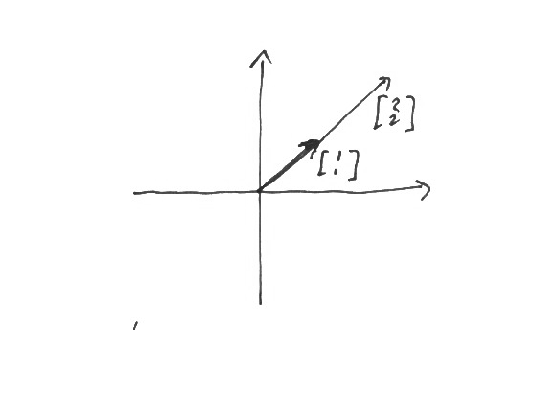

In [11]:
A = imread('demo.png');
A = rgb2gray(A);
imshow(A)

For this image, the first singular value is dominant.

In [12]:
[U,S,V] = svd(double(A));
S(1:5,1:5)


ans =

   1.0e+04 *

    8.4321         0         0         0         0
         0    0.2951         0         0         0
         0         0    0.2397         0         0
         0         0         0    0.2186         0
         0         0         0         0    0.2051



If we reconstruct the image using only the first singular value, we get a surprisingly good idea what the picture is.

Compression ratio = 0.00598

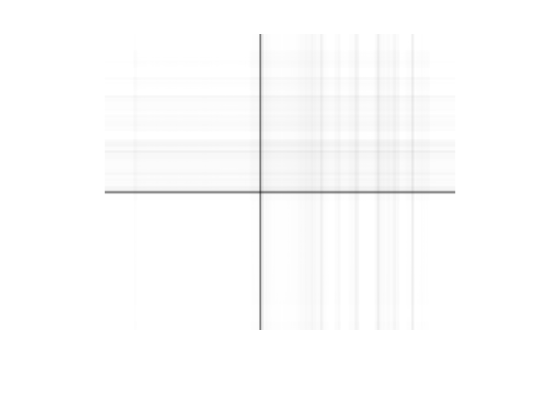

In [13]:
k = 1; % A = U S V^T
W = V';
[m,n] = size(A);
B =  U(:,1:k)*S(1:k,1:k)*W(1:k,:);
B = uint8(B);
imshow(B)
fprintf('Compression ratio = %.5f', (m*k+k+n*k)/(m*n))

This required less then 1% of the storage required to store the full matrix.

Next, we look at the size of the singular values, relative to the top singular value:

In [14]:
diag(S(10:30,10:30))'/S(1,1) % Look at singular values 10 through 30, in relative size


ans =

  Columns 1 through 7

    0.0172    0.0162    0.0157    0.0149    0.0145    0.0143    0.0135

  Columns 8 through 14

    0.0122    0.0116    0.0109    0.0106    0.0099    0.0098    0.0096

  Columns 15 through 21

    0.0091    0.0088    0.0080    0.0078    0.0078    0.0075    0.0074



The 20th singular value is less than 1% of the magnitude of the top singular value.  So, we will chop there and see what image we reconstruct.

Compression ratio = 0.11955

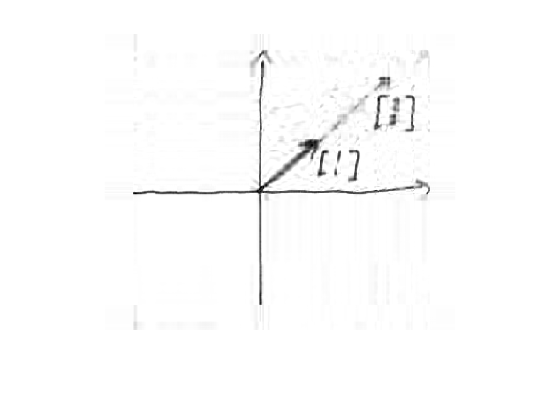

In [15]:
k = 20; % A = U S V^T
W = V';
[m,n] = size(A);
B =  U(:,1:k)*S(1:k,1:k)*W(1:k,:);
B = uint8(B);
imshow(B)
fprintf('Compression ratio = %.5f', (m*k+k+n*k)/(m*n))

With just over 10% of the storage, we can compress the image so that it is at least recognizable.  There are some issues that affect the true amount of storage.  These are related to the fact that the original image was an integer matrix and $U,V,S$ are now double precision numbers.  Whether justified, or not, we ignore that here for simplicity.